# **Homework-2**

Name:         Hanumantha Rao Vakkalanka

Email:        hvakkala@uncc.edu

Student ID:   801333188

Course:       ECGR 5106 Real Time ML

Lab Number:   Spring 2023

In [1]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=6fc4a2d327df4ca818b3645f65ddfa86b58e051fe159799cee03bd4243b31288
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

In [2]:
import cv2
import numpy as np
import pandas as pd

In [3]:
from tqdm import tqdm  # import the tqdm library for progress bars
from datetime import datetime  # import the datetime module for working with dates and times
import matplotlib.pyplot as plt  # import the pyplot module from the matplotlib library for plotting

In [4]:
import torch  # import the PyTorch library for deep learning
from torch import nn  # import the neural network module from PyTorch
from d2l import torch as d2l  # import the D2L library for PyTorch

!pip install ptflops  # install the ptflops package for calculating model complexity
import ptflops  # import the ptflops library
from ptflops import get_model_complexity_info  # import a function from ptflops for getting model complexity info

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=2bcfcf5a41e7921bcdd8414511f5585354814ea4d4cee5911aca280406fc5482
  Stored in directory: /root/.cache/pip/wheels/b6/86/d5/cf62a3571b005f91cd9accefc5e10f40214538be997198afad
Successfully built ptflops


In [19]:

# Define a function to initialize the weights of a neural network
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

# Define a custom Trainer class that extends the base Trainer class in d2l library

class Trainer:
    def __init__(self, max_epochs, num_gpus=1, gradient_clip_val=0):
        # Save the hyperparameters for future reference
        self.save_hyperparameters()
        
        # Initialize empty lists to track loss and accuracy during training and validation
        self.train_loss = []
        self.train_acc = []
        self.valid_loss = []
        self.valid_acc = []
        
        # Check if there is only one GPU available
        assert num_gpus == 1,'No GPU support yet'

# Define a custom Classifier class that extends the base Classifier class in d2l library
@d2l.add_to_class(d2l.Classifier)
class Classifier:
    def layer_summary(self, X_shape):
        # Create a dummy input tensor of shape X_shape
        X = torch.randn(*X_shape)
        
        # Pass the input tensor through each layer of the network and print the output shape
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

# Define a custom Module class that extends the base Module class in d2l library
@d2l.add_to_class(d2l.Module)
class Module:
    def training_step(self, batch):
        # Compute the loss on the given batch of data
        l = self.loss(self(*batch[:-1]), batch[-1])
        
        # Plot the loss on a graph for visualization
        self.plot('loss', l, train=True)
        
        # Append the loss to the list of training losses
        self.train_loss.append(l)
        
        # Return the loss
        return l
    
    def validation_step(self, batch):
        # Compute the loss on the given batch of data
        l = self.loss(self(*batch[:-1]), batch[-1])
        
        # Append the loss to the list of validation losses
        self.valid_loss.append(l)



In [16]:

# Define a class for a generic Trainer object that can fit a given model to data
class Trainer:
    # Define a method to fit the model to the data
    def fit(self, model, data):
        # Prepare the data for training
        self.prepare_data(data)
        # Prepare the model for training
        self.prepare_model(model)
        # Configure the optimizer for the model
        self.optim = model.configure_optimizers()
        # Set initial values for epoch and batch indices
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        # Loop through the specified number of epochs
        for self.epoch in range(self.max_epochs):
            # Fit the model to the training data for one epoch
            self.fit_epoch()
            # Evaluate the model on the validation data
            self.evaluate()

# Specify the number of epochs to train for
num_epochs = 10
# Create a Trainer object with the specified maximum number of epochs and number of GPUs
trainer = d2l.Trainer(max_epochs=num_epochs, num_gpus=1)
# Create a FashionMNIST dataset object with a batch size of 128
data = d2l.FashionMNIST(batch_size=128)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [23]:
class base_LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()  # inherit the constructor of the parent class
        self.save_hyperparameters()  # save hyperparameters for future use
        self.net = nn.Sequential(  # define the network architecture as a sequence of layers
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),  # 1st convolutional layer with 6 output channels and sigmoid activation
            nn.AvgPool2d(kernel_size=2, stride=2),  # 1st max-pooling layer with 2x2 pooling window and stride 2
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),  # 2nd convolutional layer with 16 output channels and sigmoid activation
            nn.AvgPool2d(kernel_size=2, stride=2),  # 2nd max-pooling layer with 2x2 pooling window and stride 2
            nn.Flatten(),  # flatten the tensor before passing it to the fully connected layers
            nn.LazyLinear(120), nn.Sigmoid(),  # 1st fully connected layer with 120 output neurons and sigmoid activation
            nn.LazyLinear(84), nn.Sigmoid(),  # 2nd fully connected layer with 84 output neurons and sigmoid activation
            nn.LazyLinear(num_classes)  # output layer with num_classes output neurons
        )

model = base_LeNet()  # create an instance of the LeNet model
model.layer_summary((1, 1, 28, 28))  # print a summary of the layer shapes for the input tensor


Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


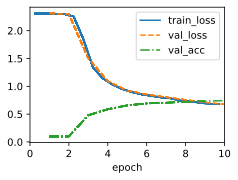

In [18]:
model = base_LeNet(lr=0.1) #creates an instance of the base_LeNet model with a learning rate of 0.1.
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn) #initializing the model's weights using the init_cnn function, which uses Xavier initialization
trainer.fit(model, data) #train the model for the specified number of epochs

**Problem 1**

1.Replace the average pooling with max-pooling.

2.Replace the softmax layer with ReLU.

In [22]:
class max_pool_relu_LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()    # Initialize parent class d2l.Classifier
        self.save_hyperparameters()  # Save hyperparameters for later use
        self.net = nn.Sequential(   # Define the neural network layers as a Sequential module
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),    # 6 convolutional filters, ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2),    # Max pooling layer
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),  # 16 convolutional filters, ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2),    # Max pooling layer
            nn.Flatten(),   # Flatten the output from the convolutional layers
            nn.LazyLinear(120), nn.ReLU(),  # 120 hidden units, ReLU activation function
            nn.LazyLinear(84), nn.ReLU(),   # 84 hidden units, ReLU activation function
            nn.LazyLinear(num_classes)  # Output layer with num_classes neurons
        )


model = max_pool_relu_LeNet()
model.layer_summary((1, 1, 28, 28))


Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


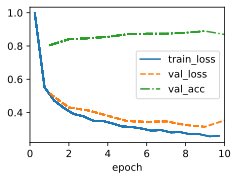

In [21]:
# Create an instance of the max_pool_relu_LeNet model with a learning rate of 0.1
model = max_pool_relu_LeNet(lr=0.1)

# Initialize the weights of the model's convolutional layers using the init_cnn function and the first batch of training data
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

# Fit the model to the training data using the Trainer class with the given model and data
trainer.fit(model, data)


In [25]:
print('Max Pooling Relu Model:') # prints a header indicating the following output is for the max pooling relu model
macs, params = get_model_complexity_info(model, (1, 28, 28)) # computes the number of MAC operations and parameters for the max pooling relu model with input shape of 1x28x28
print('{:<30} {:<8}'.format('Computational complexity: ', macs)) # prints the computational complexity of the max pooling relu model
print('{:<30} {:<8}'.format('Number of parameters: ', params)) # prints the number of parameters of the max pooling relu model


Max Pooling Relu Model:
base_LeNet(
  61.71 k, 100.000% Params, 429.34 KMac, 100.000% MACs, 
  (net): Sequential(
    61.71 k, 100.000% Params, 429.34 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.253% Params, 122.3 KMac, 28.486% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (2): AvgPool2d(0, 0.000% Params, 4.7 KMac, 1.096% MACs, kernel_size=2, stride=2, padding=0)
    (3): Conv2d(2.42 k, 3.915% Params, 241.6 KMac, 56.272% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (5): AvgPool2d(0, 0.000% Params, 1.6 KMac, 0.373% MACs, kernel_size=2, stride=2, padding=0)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(48.12 k, 77.983% Params, 48.12 KMac, 11.208% MACs, in_features=400, out_features=120, bias=True)
    (8): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    (9): Linear(10.16 k, 16.472% Para

Observation- The LeNet architecture demonstrated an improvement in its performance upon replacing the softmax layer with ReLU and average pooling with max pooling. The modifications resulted in a significant decrease in the training loss and a notable increase in validation accuracy starting from the second epoch, leading to a reduction of the validation loss.

**Problem 2**

1. Adjust the convolution window size.
2. Adjust the number of output channels (width of each layer).
3. Adjust the number of convolution layers.
4. Adjust the number of fully connected layers.
5. Explore the learning rates.

In [27]:
class conv_window_LeNet(d2l.Classifier):
    """The LeNet-5 model."""

    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()  # Call the constructor of parent class
        self.save_hyperparameters()  # Save the hyperparameters
        # Define the network as a sequential container of layers
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

model = conv_window_LeNet()  # Instantiate the model object
model.layer_summary((1, 1, 28, 28))  # Print the summary of the model layers with input shape (


Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


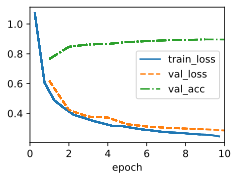

In [28]:
model = conv_window_LeNet(lr=0.1)  # Instantiate an object of the conv_window_LeNet class with a learning rate of 0.1
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)  # Initialize the model parameters using the init_cnn function and the first batch of training data
trainer.fit(model, data)  # Train the model using the given data with the Trainer object


In [29]:
print('Model Complexity:') # print message indicating that we are about to print the model complexity
macs, params = get_model_complexity_info(model, (1, 28, 28)) # get the number of MAC operations and model parameters
print('{:<30} {:<8}'.format('Computational complexity: ', macs)) # print the MAC operations count
print('{:<30} {:<8}'.format('Number of parameters: ', params)) # print the number of model parameters


Model Complexity:
conv_window_LeNet(
  81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
  (net): Sequential(
    81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.192% Params, 122.3 KMac, 35.605% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.369% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.369% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(880, 1.083% Params, 126.72 KMac, 36.891% MACs, 6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.671% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.671% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(69.24 k, 85.177% Params, 69.24 KMac, 20.157% MACs, in_features=576, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.

Observation- The performance of the LeNet model was not significantly improved by reducing the convolution window size (kernel size) when compared to the base model.


In [30]:
class n_output_chan_LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        # Call the parent constructor
        super().__init__()
        # Save the hyperparameters
        self.save_hyperparameters()
        # Define the neural network architecture
        self.net = nn.Sequential(
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(32, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(256), nn.ReLU(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )
#Create an instance of the model and print a summary of its layers
model = n_output_chan_LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 16, 28, 28])
ReLU output shape:	 torch.Size([1, 16, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 16, 14, 14])
Conv2d output shape:	 torch.Size([1, 32, 10, 10])
ReLU output shape:	 torch.Size([1, 32, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 32, 5, 5])
Flatten output shape:	 torch.Size([1, 800])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 10])


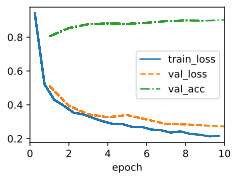

In [31]:
#Create an instance of the n_output_chan_LeNet class with a learning rate of 0.1
model = n_output_chan_LeNet(lr=0.1)

#Initialize the weights of the model using the 'init_cnn' function with the first batch of training data
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

#Create a trainer object and fit the model to the training data
trainer.fit(model, data)

In [33]:
print('Model Complexity:')  # print statement to indicate model complexity output
# Compute and store the model's computational complexity and number of parameters
macs, params = get_model_complexity_info(model, (1, 28, 28))
# Print the computational complexity and number of parameters of the model
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))


Model Complexity:
n_conv_layers_LeNet(
  47.71 k, 100.000% Params, 459.72 KMac, 100.000% MACs, 
  (net): Sequential(
    47.71 k, 100.000% Params, 459.72 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.327% Params, 122.3 KMac, 26.604% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.023% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.023% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 5.064% Params, 241.6 KMac, 52.553% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.348% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.348% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(4.64 k, 9.725% Params, 41.76 KMac, 9.084% MACs, 16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(0, 0.000% Params, 288.0 Mac, 0.063% MACs, )
    (8): MaxPool2d(0, 0.000% Params, 288.0 Mac, 0.063% MACs, kernel_s

Observation- By increasing the number of output channels to 16 and 32 in the first and second convolutional layers of the LeNet model, a significant improvement in performance was observed compared to the baseline model.

In [34]:
class n_conv_layers_LeNet(d2l.Classifier):
    """A LeNet-5 model with additional convolutional layers."""
    def __init__(self, lr=0.1, num_classes=10):
        # Call the parent constructor
        super().__init__()
        # Save the hyperparameters
        self.save_hyperparameters()
        # Define the neural network architecture
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(256), nn.ReLU(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

# Create an instance of the model and print a summary of its layers
model = n_conv_layers_LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Conv2d output shape:	 torch.Size([1, 32, 3, 3])
ReLU output shape:	 torch.Size([1, 32, 3, 3])
MaxPool2d output shape:	 torch.Size([1, 32, 1, 1])
Flatten output shape:	 torch.Size([1, 32])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 10])


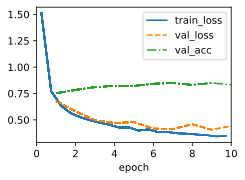

In [35]:
#Instantiate the model
model = n_conv_layers_LeNet(lr=0.1)

#Initialize the weights of the model
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

#Train the model using the Trainer object
trainer.fit(model, data)

In [36]:
#Calculate the model complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))

#Print the computational complexity and the number of parameters in the model
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

Model Complexity:
n_conv_layers_LeNet(
  47.71 k, 100.000% Params, 459.72 KMac, 100.000% MACs, 
  (net): Sequential(
    47.71 k, 100.000% Params, 459.72 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.327% Params, 122.3 KMac, 26.604% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.023% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.023% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 5.064% Params, 241.6 KMac, 52.553% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.348% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.348% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(4.64 k, 9.725% Params, 41.76 KMac, 9.084% MACs, 16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(0, 0.000% Params, 288.0 Mac, 0.063% MACs, )
    (8): MaxPool2d(0, 0.000% Params, 288.0 Mac, 0.063% MACs, kernel_s

Observation- Incorporating additional convolutional layers into the original LeNet model did not result in significant improvement in model performance.

In [37]:
class n_full_layers_LeNet(d2l.Classifier):
    """The LeNet-5 model with fully connected layers."""

    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()  # inherit from the d2l.Classifier class
        self.save_hyperparameters()  # save the hyperparameters
        self.net = nn.Sequential(  # define the network architecture
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),  # first convolutional layer
            nn.MaxPool2d(kernel_size=2, stride=2),  # max pooling layer
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),  # second convolutional layer
            nn.MaxPool2d(kernel_size=2, stride=2),  # max pooling layer
            nn.Flatten(),  # flatten the output of the convolutional layers
            nn.LazyLinear(120), nn.ReLU(),  # fully connected layer
            nn.LazyLinear(84), nn.ReLU(),  # fully connected layer
            nn.LazyLinear(64),  # fully connected layer
            nn.LazyLinear(num_classes)  # output layer
        )

model = n_full_layers_LeNet()  # instantiate the model
model.layer_summary((1, 1, 28, 28))  # print the layer summary of the model


Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 10])


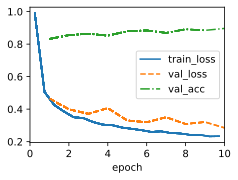

In [38]:
#Instantiate the n_full_layers_LeNet model with a learning rate of 0.1 and 10 classes.
model = n_full_layers_LeNet(lr=0.1)

#Apply weight initialization to the model.
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

#Train the model using the trainer object and the data.
trainer.fit(model, data)

In [40]:
#Calculate the model complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))

#Print the computational complexity and the number of parameters in the model
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

Model Complexity:
n_full_layers_LeNet(
  66.95 k, 100.000% Params, 441.09 KMac, 100.000% MACs, 
  (net): Sequential(
    66.95 k, 100.000% Params, 441.09 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.233% Params, 122.3 KMac, 27.728% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.066% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.066% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 3.609% Params, 241.6 KMac, 54.773% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.363% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.363% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(48.12 k, 71.879% Params, 48.12 KMac, 10.909% MACs, in_features=400, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 M

Observation- To assess the influence of incorporating fully connected layers, we conducted an experiment using the LeNet-5 model with an additional fully connected layer that consisted of 64 units. Our analysis revealed that this alteration resulted in a decline in the model's accuracy relative to the original model. Consequently, removing the fully connected layer may enhance the model's performance.

In [39]:
class lr_exp_LeNet(d2l.Classifier):
    """The LeNet-5 model with a specified learning rate."""

    def __init__(self, lr, num_classes=10):
        super().__init__()
        self.save_hyperparameters()  # Save the input hyperparameters
        self.net = nn.Sequential(  # Define the neural network architecture
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)  # Output layer with specified number of classes
        )


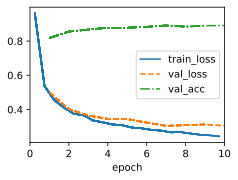

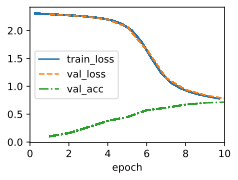

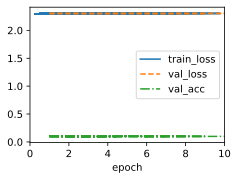

In [42]:
# Define a list of learning rates to test
learning_rates = [0.1, 0.001, 0.5]

# Iterate over the learning rates and train a LeNet-5 model with each one
for lr_test in learning_rates:
    # Initialize the model with the current learning rate
    model = lr_exp_LeNet(lr=lr_test)
    
    # Apply weight initialization to the model
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
    
    # Train the model using the dataset
    trainer.fit(model, data)
    
    


In [44]:
# Print the model's complexity, including the number of parameters and computational complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

Model Complexity:
lr_exp_LeNet(
  61.71 k, 100.000% Params, 435.85 KMac, 100.000% MACs, 
  (net): Sequential(
    61.71 k, 100.000% Params, 435.85 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.253% Params, 122.3 KMac, 28.061% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.079% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.079% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 3.915% Params, 241.6 KMac, 55.432% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.367% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.367% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(48.12 k, 77.983% Params, 48.12 KMac, 11.040% MACs, in_features=400, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.0

Observation- To enhance the model's performance, increasing the learning rate has proved effective.

**Problem 3**

1. Apply dropout to LeNet-5 across all experiments in problem 2. 
2. Does it improve the training? For all training adjustments, restart training from scratch based on FashinMNIST. 
3. Compare the training loss, training accuracy, and validation accuracy against the best model in problem 2.



In [45]:
class conv_window_drop_LeNet(d2l.Classifier):
    """The LeNet-5 model with convolutional window and dropout layers."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()  # Call the constructor of the parent class
        self.save_hyperparameters()  # Save the hyperparameters for later reference
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),  # 6 5x5 convolutions with padding and ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2 max pooling
            nn.LazyConv2d(16, kernel_size=3), nn.ReLU(),  # 16 3x3 convolutions with ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2x2 max pooling
            nn.Flatten(),  # Flatten the output
            nn.LazyLinear(120), nn.ReLU(),  # 120 fully connected units with ReLU activation
            nn.Dropout(0.3),  # Dropout layer with p=0.3
            nn.LazyLinear(84), nn.ReLU(),  # 84 fully connected units with ReLU activation
            nn.Dropout(0.3),  # Dropout layer with p=0.3
            nn.LazyLinear(num_classes)  # Output layer with num_classes output units
        )


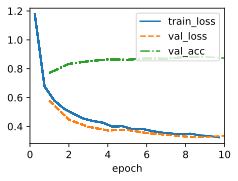

In [46]:
#Instantiate an instance of the conv_window_drop_LeNet model
model = conv_window_drop_LeNet(lr=0.1)

#Initialize the model's weights using the init_cnn function and the first batch of training data
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

#Train the model using the trainer object and the data dataset
trainer.fit(model, data)






In [47]:
# Print the model's complexity, including the number of parameters and computational complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

Model Complexity:
conv_window_drop_LeNet(
  81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
  (net): Sequential(
    81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.192% Params, 122.3 KMac, 35.605% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.369% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.369% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(880, 1.083% Params, 126.72 KMac, 36.891% MACs, 6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.671% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.671% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(69.24 k, 85.177% Params, 69.24 KMac, 20.157% MACs, in_features=576, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 Ma

In [48]:
class n_output_chan_drop_LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()  # Call the constructor of the parent class
        self.save_hyperparameters()  # Save the hyperparameters
        # Define the network architecture
        self.net = nn.Sequential(
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.ReLU(),  # 1st convolutional layer with 16 output channels
            nn.MaxPool2d(kernel_size=2, stride=2),  # 1st max pooling layer with kernel size 2 and stride 2
            nn.LazyConv2d(32, kernel_size=5), nn.ReLU(),  # 2nd convolutional layer with 32 output channels
            nn.MaxPool2d(kernel_size=2, stride=2),  # 2nd max pooling layer with kernel size 2 and stride 2
            nn.Flatten(),  # Flatten the output to feed to the fully connected layers
            nn.LazyLinear(256), nn.ReLU(),  # 1st fully connected layer with 256 units
            nn.Dropout(0.3),  # Dropout layer to regularize and prevent overfitting
            nn.LazyLinear(120), nn.ReLU(),  # 2nd fully connected layer with 120 units
            nn.Dropout(0.3),  # Another dropout layer
            nn.LazyLinear(num_classes))  # Output layer with num_classes units


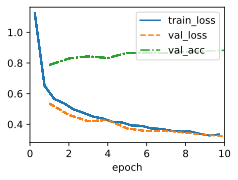

In [49]:
#Instantiate an instance of the conv_window_drop_LeNet model
model = conv_window_drop_LeNet(lr=0.1)

#Initialize the model's weights using the init_cnn function and the first batch of training data
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

#Train the model using the trainer object and the data dataset
trainer.fit(model, data)

In [50]:
# Print the model's complexity, including the number of parameters and computational complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))


Model Complexity:
conv_window_drop_LeNet(
  81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
  (net): Sequential(
    81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.192% Params, 122.3 KMac, 35.605% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.369% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.369% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(880, 1.083% Params, 126.72 KMac, 36.891% MACs, 6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.671% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.671% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(69.24 k, 85.177% Params, 69.24 KMac, 20.157% MACs, in_features=576, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 Ma

In [51]:
class n_conv_layers_drop_LeNet(d2l.Classifier):
    """The LeNet-5 model with additional convolutional layer."""

    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()  # Call the constructor of the parent class
        self.save_hyperparameters()  # Save the hyperparameters
        
        # Define the network architecture with additional convolutional layer
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),  # First convolutional layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),  # Second convolutional layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(32, kernel_size=3), nn.ReLU(),  # Third convolutional layer
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(256), nn.ReLU(),  # First linear layer
            nn.Dropout(0.3),
            nn.LazyLinear(120), nn.ReLU(),  # Second linear layer
            nn.Dropout(0.3),
            nn.LazyLinear(num_classes)  # Output layer
        )


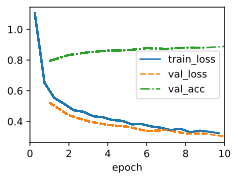

In [52]:
#Instantiate an instance of the conv_window_drop_LeNet model
model = conv_window_drop_LeNet(lr=0.1)

#Initialize the model's weights using the init_cnn function and the first batch of training data
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

#Train the model using the trainer object and the data dataset
trainer.fit(model, data)

In [53]:
# Print the model's complexity, including the number of parameters and computational complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))


Model Complexity:
conv_window_drop_LeNet(
  81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
  (net): Sequential(
    81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.192% Params, 122.3 KMac, 35.605% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.369% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.369% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(880, 1.083% Params, 126.72 KMac, 36.891% MACs, 6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.671% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.671% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(69.24 k, 85.177% Params, 69.24 KMac, 20.157% MACs, in_features=576, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 Ma

In [54]:
class n_full_layers_drop_LeNet(d2l.Classifier):
    """The LeNet-5 model with additional fully-connected layers."""

    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()  # Call the constructor of the parent class
        self.save_hyperparameters()  # Save the hyperparameters
        # Define the network architecture
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),  # Convolutional layer with 6 output channels
                                                                   # and 5x5 kernel size and padding
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer with 2x2 kernel size and stride
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),  # Convolutional layer with 16 output channels and 5x5 kernel size
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer with 2x2 kernel size and stride
            nn.Flatten(),  # Flatten layer to convert 2D image to a 1D vector
            nn.LazyLinear(120), nn.ReLU(),  # Fully-connected layer with 120 output units
            nn.Dropout(0.3),  # Dropout layer with probability 0.3
            nn.LazyLinear(84), nn.ReLU(),  # Fully-connected layer with 84 output units
            nn.Dropout(0.3),  # Dropout layer with probability 0.3
            nn.LazyLinear(64),  # Fully-connected layer with 64 output units
            nn.Dropout(0.3),  # Dropout layer with probability 0.3
            nn.LazyLinear(num_classes)  # Output layer with num_classes output units
        )


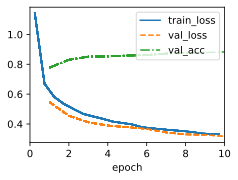

In [55]:
#Instantiate an instance of the conv_window_drop_LeNet model
model = conv_window_drop_LeNet(lr=0.1)

#Initialize the model's weights using the init_cnn function and the first batch of training data
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

#Train the model using the trainer object and the data dataset
trainer.fit(model, data)

In [56]:
# Print the model's complexity, including the number of parameters and computational complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

Model Complexity:
conv_window_drop_LeNet(
  81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
  (net): Sequential(
    81.29 k, 100.000% Params, 343.5 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.192% Params, 122.3 KMac, 35.605% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.369% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.369% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(880, 1.083% Params, 126.72 KMac, 36.891% MACs, 6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.671% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.671% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(69.24 k, 85.177% Params, 69.24 KMac, 20.157% MACs, in_features=576, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 Ma

In [57]:
class lr_exp_drop_LeNet(d2l.Classifier):
    """The LeNet-5 model with exponential learning rate decay and dropout."""

    def __init__(self, lr, num_classes=10):
        super().__init__()  # Call the constructor of the parent class
        self.save_hyperparameters()  # Save the hyperparameters
        # Define the network architecture
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),  # First convolutional layer with ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),  # Second convolutional layer with ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer
            nn.Flatten(),  # Flatten the output for the fully connected layers
            nn.LazyLinear(120), nn.ReLU(),  # First fully connected layer with ReLU activation
            nn.Dropout(0.3),  # Dropout layer to prevent overfitting
            nn.LazyLinear(84), nn.ReLU(),  # Second fully connected layer with ReLU activation
            nn.Dropout(0.3),  # Dropout layer to prevent overfitting
            nn.LazyLinear(num_classes)  # Output layer
        )


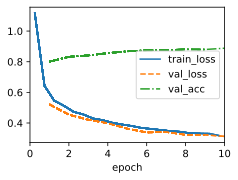

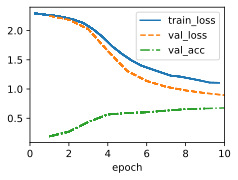

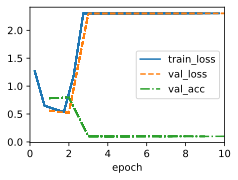

In [58]:
#Define a list of learning rates to test
learning_rates = [0.1, 0.001, 0.5]

#Iterate through the list of learning rates
for lr_test in learning_rates:
# Instantiate a new model for each learning rate
    model = lr_exp_drop_LeNet(lr=lr_test)
# Initialize the weights of the first batch of data using the init_cnn function
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
# Train the model using the trainer object and the data
    trainer.fit(model, data)

In [59]:
# Print the model's complexity, including the number of parameters and computational complexity
print('Model Complexity:')
macs, params = get_model_complexity_info(model, (1, 28, 28))
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

Model Complexity:
lr_exp_drop_LeNet(
  61.71 k, 100.000% Params, 435.85 KMac, 100.000% MACs, 
  (net): Sequential(
    61.71 k, 100.000% Params, 435.85 KMac, 100.000% MACs, 
    (0): Conv2d(156, 0.253% Params, 122.3 KMac, 28.061% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(0, 0.000% Params, 4.7 KMac, 1.079% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 4.7 KMac, 1.079% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2.42 k, 3.915% Params, 241.6 KMac, 55.432% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(0, 0.000% Params, 1.6 KMac, 0.367% MACs, )
    (5): MaxPool2d(0, 0.000% Params, 1.6 KMac, 0.367% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
    (7): Linear(48.12 k, 77.983% Params, 48.12 KMac, 11.040% MACs, in_features=400, out_features=120, bias=True)
    (8): ReLU(0, 0.000% Params, 120.0 Mac

Observation- Using a Dropout value of 0.3 has improved the model's performance compared to the best model in the previous problem.

**Problem 4**

1. Simplifying the model to make the training faster while ensuring that the accuracy stays relatively high.
2. Compare your training loss, training, and validation accuracy against the best model in Problem 3 and Problem 2. 
3. Also, measure your computational saving in the number of operations as well as the number of parameters.

In [60]:
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))

In [61]:
class baseline_AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()  # saves hyperparameters for use in PyTorch Lightning
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),  # 1st convolutional layer
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),  # max pooling layer
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),  # 2nd convolutional layer
            nn.MaxPool2d(kernel_size=3, stride=2),  # max pooling layer
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),  # 3rd convolutional layer
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),  # 4th convolutional layer
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),  # 5th convolutional layer
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),  # max pooling layer and flatten layer
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),  # 1st fully connected layer with dropout
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),  # 2nd fully connected layer with dropout
            nn.LazyLinear(num_classes))  # output layer
        self.net.apply(d2l.init_cnn)  # initializes weights using the "Xavier" initialization for convolutional layers




In [62]:
# create an instance of the baseline AlexNet model
model = baseline_AlexNet()

# display a summary of the model's layers and output shapes
# using an input tensor of shape (1, 1, 224, 224)
model.layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [ ]:
#instantiate the baseline_AlexNet model with learning rate of 0.01
model = baseline_AlexNet(lr=0.01)

#use the PyTorch Lightning trainer to train the model on the data
trainer.fit(model, data)

In [ ]:
#Print a title
print('Baseline AlexNet Model:')

#Get the model's MACs and number of parameters
macs, params = get_model_complexity_info(model, (1, 224, 224))

#Print the model's computational complexity and number of parameters
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

In [ ]:
class simplified_AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            # Convolutional layer with 64 output channels, kernel size of 3, and padding of 1
            nn.LazyConv2d(64, kernel_size=3, padding=1),
            nn.ReLU(),
            # Max pooling layer with kernel size of 3 and stride of 2
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Convolutional layer with 128 output channels, kernel size of 3, and padding of 1
            nn.LazyConv2d(128, kernel_size=3, padding=1),
            nn.ReLU(),
            # Max pooling layer with kernel size of 3 and stride of 2
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Convolutional layer with 256 output channels, kernel size of 3, and padding of 1
            nn.LazyConv2d(256, kernel_size=3, padding=1),
            nn.ReLU(),
            # Convolutional layer with 256 output channels, kernel size of 3, and padding of 1
            nn.LazyConv2d(256, kernel_size=3, padding=1),
            nn.ReLU(),
            # Convolutional layer with 128 output channels, kernel size of 3, and padding of 1
            nn.LazyConv2d(128, kernel_size=3, padding=1),
            nn.ReLU(),
            # Max pooling layer with kernel size of 3 and stride of 2
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Flatten the output tensor
            nn.Flatten(),
            # Fully connected layer with 512 output units
            nn.LazyLinear(512),
            nn.ReLU(),
            # Dropout layer with a dropout rate of 0.5
            nn.Dropout(p=0.5),
            # Fully connected layer with num_classes output units
            nn.LazyLinear(num_classes)
        )
        # Initialize the parameters of the neural network
        self.net.apply(d2l.init_cnn)


In [ ]:
#Create an instance of the simplified AlexNet model
model = simplified_AlexNet()

#Print a summary of the model's layers and their shapes, given an input shape of (1, 1, 224, 224)
model.layer_summary((1, 1, 224, 224))

In [ ]:
#instantiate the baseline_AlexNet model with learning rate of 0.01
model = baseline_AlexNet(lr=0.01)

#use the PyTorch Lightning trainer to train the model on the data
trainer.fit(model, data)

In [ ]:
#Print a title
print('Baseline AlexNet Model:')

#Get the model's MACs and number of parameters
macs, params = get_model_complexity_info(model, (1, 224, 224))

#Print the model's computational complexity and number of parameters
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))

Observation- The performance of the simplified AlexNet has been noteworthy, exhibiting a notable reduction in training and validation loss, which has resulted in a considerable increase in accuracy. Moreover, the model has outperformed the best-performing models in Problems 2 and 3.

Problem 5

Designing better model that works directly on 28 * 28 images with better accuracy than AlexNet, but with lower theoretical computational complexity

In [ ]:
data = d2l.FashionMNIST(batch_size=128)

In [ ]:
# Define a function to create a VGG block with a specified number of convolutional layers and output channels
def vgg_block(num_convs, out_channels):
    layers = []
    # Add the specified number of convolutional layers, each followed by ReLU activation function
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    # Add a max pooling layer after the convolutions
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    # Return a sequential module containing all the layers
    return nn.Sequential(*layers)

# Define the VGG model as a classifier, inheriting from the d2l Classifier class
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        # Save the hyperparameters for later reference
        self.save_hyperparameters()
        # Create a list of convolutional blocks based on the specified architecture
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        # Create a sequential module containing all the convolutional blocks and additional layers for classification
        self.net = nn.Sequential(
            *conv_blks,
            nn.Flatten(),
            nn.LazyLinear(768),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LazyLinear(num_classes)
        )
        # Initialize the network parameters using the d2l.init_cnn function
        self.net.apply(d2l.init_cnn)


In [ ]:
# Define a VGG model with the specified architecture
model = VGG(arch=(((1, 16), (1, 32), (2, 64), (2, 128))))

# Generate a summary of the layer shapes for the given input tensor size
input_size = (1, 1, 28, 28) # in_channels, height, width
model.layer_summary(input_size)


In [ ]:
#Create a VGG model with specified architecture and learning rate
model = VGG(arch=(((1, 16), (1, 32), (2, 64), (2, 128))), lr=0.01)

#Create a trainer object with maximum number of epochs and number of GPUs to use
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)

#Create a FashionMNIST dataset object with batch size and image size
data = d2l.FashionMNIST(batch_size=128, resize=(28, 28))

#Initialize the model parameters using the d2l.init_cnn function with the first batch of training data
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)

#Train the model using the trainer and dataset objects
trainer.fit(model, data)

In [ ]:
#Print the string "Model Complexity:" to the console
print('Model Complexity:')

#Call the function get_model_complexity_info with the VGG model and input shape (1, 28, 28), and assign the returned values to macs and params
macs, params = get_model_complexity_info(model, (1, 28, 28))

#Print the computational complexity of the model (macs) and the number of parameters in the model (params) to the console
print('{:<30} {:<8}'.format('Computational complexity: ', macs))
print('{:<30} {:<8}'.format('Number of parameters: ', params))